# Guide to SARIMAX



### References 
1. Best Starting Point: [A Guide to Time Series Forecasting with ARIMA in Python 3](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)
2. More detailed examples: http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
3. How to choose model parameters:
    * [Tutorial-forecasting-with-seasonal-arima](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima)
    * [Stack overflow: Choosing seasonal parameters](https://stackoverflow.com/questions/44235558/statespace-sarimax-model-why-the-model-use-all-the-data-to-train-mode-and-pred)

In [1]:
import pandas as pd
import numpy as np

# Plotting parameters
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,6)
from IPython.display import display

# Statsmodels
import statsmodels as sm 
import statsmodels.tsa.api as sm_tsa

# Python Function 
import itertools

C:\Users\kanna sithan\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


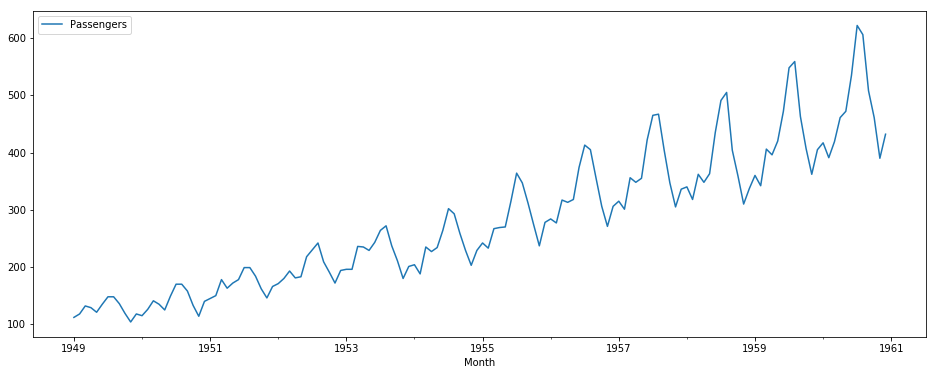

In [2]:
# Import Data 
df_passengers = pd.read_csv('data/airline-passengers.csv', parse_dates =['Month'], index_col=['Month'])
display(df_passengers.head())

# Plot Figures 
df_passengers.plot()
plt.show()

## Train-test Split 

Using the TimeSeriesSplit function from sklearn:
* Training set has size `i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1)` in the i-th split,  
* Test set of size ``n_samples//(n_splits + 1)``, where `n_samples` is the number of samples.



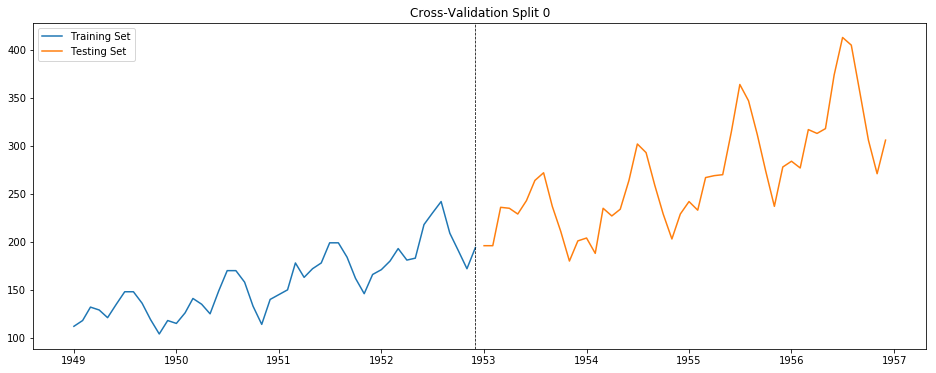

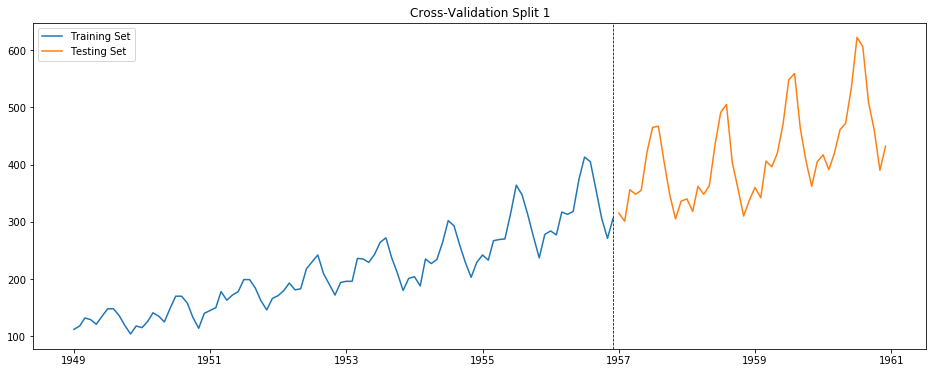

In [3]:
# Train-test split 
from sklearn.model_selection import TimeSeriesSplit

ts_split = TimeSeriesSplit(n_splits=2)
for split_num, (train_idx, test_idx) in enumerate(ts_split.split(df_passengers)):    
    y_train, y_test = df_passengers.iloc[train_idx], df_passengers.iloc[test_idx]
    
    # ----- Plot the Training & Testing Sets ----- #
    plt.plot(y_train, label='Training Set')
    plt.plot(y_test, label='Testing Set')
    plt.title('Cross-Validation Split {}'.format(split_num))
    plt.legend()
    plt.axvline(x=y_train.index[-1], color='k', linestyle='--', linewidth=0.75)
    plt.show()

### Notes
##### Lag operator
The lag operator $L$ is defined to be $L^{a}y_{t} = y_{t-a}$


### ARIMA $(p,d,q)$

The ARIMA model is specified with parameters $(p, d, q)$. 
In terms of a univariate structural model, this can be represented as
$$ y_t  = u_t + \eta_t $$

$$\left( 1- \sum_{i=1}^p\phi_i L^i \right)\left( 1 - L \right)^d u_t = A_t +  \left( 1 + \sum_{j=1}^q\theta_i L^i \right)\epsilon_t $$
where $\eta_t$ is only applicable in the case of measurement error (although it is also used in the case of a pure regression model, i.e. if $p=q=0$).

| Term        | &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Formulation  &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; | Parameter  |
| ------------- |:--------------------:| -------------
|AR      | $\left( 1- \sum_{i=1}^p\phi_i L^i \right)$ | $p$ |
| I     | $\left( 1 - L \right)^d $     |   $d$ |
| MA | $ \left( 1 + \sum_{j=1}^q\theta_i L^i \right) $     |    $q$ |
| Trend | $A_t$ | - 



### SARIMA $(p,d,q)\times (P, D, Q)_s$

The SARIMA model is specified $(p, d, q) \times (P, D, Q)_s$ where the $(P, D, Q)_s$ are another set of "ARIMA" parameters for the seasonal component 

$$ y_t  = u_t + \eta_t $$

$$\left( 1- \sum_{i=1}^p\phi_i L^i \right)\left( 1 - L \right)^d \left( 1- \sum_{i=1}^P\tilde{\phi}_i L^{i+s} \right)\left( 1 - L^s \right)^D u_t = A_t + \left( 1 + \sum_{j=1}^q\theta_j L^j \right)  \left( 1 + \sum_{j=1}^Q\tilde{\theta}_j L^{j+s} \right)\epsilon_t $$


| Term        | &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Formulation  &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; | Parameter  |
| ------------- |:--------------------:| -------------
|s_AR      | $\left( 1- \sum_{i=1}^P\tilde{\phi}_i L^{i+s} \right)$ | $P$ |
| s_I     | $\left( 1 - L^{s} \right)^D $     |   $D$ |
| s_MA | $ \left( 1 + \sum_{j=1}^Q\tilde{\theta_j} L^{j+s} \right) $     |    $Q$ |


### SARIMAX $(p,d,q)\times (P, D, Q)_s$

This model is the one used when $B$ exogenous regressors, $x_{i,t}$ are provided at every time-instant $t$.

$$ y_t = \sum_{i=1}^{B}\beta_{i} x_{i,t} + u_t $$ 
where
$$\left( 1- \sum_{i=1}^p\phi_i L^i \right)\left( 1 - L \right)^d \left( 1- \sum_{i=1}^P\tilde{\phi}_i L^{i+s} \right)\left( 1 - L^s \right)^D u_t = A_t + \left( 1 + \sum_{j=1}^q\theta_j L^j \right)  \left( 1 + \sum_{j=1}^Q\tilde{\theta}_j L^{j+s} \right)\epsilon_t $$

In [4]:
# Load SARIMA
p = d = q = range(2)
pdq_grid = list(itertools.product(p, d, q))
PDQS_grid = [(x[0], x[1], x[2], 12) for x in pdq_grid] # Generate all different
pdq_x_PDQS_grid = list(itertools.product(pdq_grid, PDQS_grid))


results_dict = dict()

for pdq, PDQS in pdq_x_PDQS_grid:
    model_param = '{} x {}'.format(pdq, PDQS) 
    
    try:
        mod = sm_tsa.statespace.SARIMAX(y_train, 
                                        order=pdq, 
                                        seasonal_order=PDQS,   
                                        enforce_stationarity=True,
                                        enforce_invertibility=False)
        results = mod.fit()
        results_dict.update({model_param: results.aic})
    except Exception as e:
        continue
#         print(model_param)
#         print(e)


C:\Users\kanna sithan\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [5]:
# Best Model Parameters 
a = [i.strip() for i in pd.DataFrame(results_dict, index=['AIC']).T.sort_values(by='AIC').iloc[0].name.split('x')]
pdq = eval(a[0])
PDQS = eval(a[1])
print('Best SARIMA model paramers are {} x {}'.format(pdq, PDQS) )

Best SARIMA model paramers are (1, 1, 0) x (1, 1, 0, 12)


In [6]:
mod = sm_tsa.statespace.SARIMAX(y_train, 
                                order=pdq, 
                                seasonal_order=PDQS,   
                                enforce_stationarity=True,
                                enforce_invertibility=False)
results = mod.fit()

In [7]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         Passengers   No. Observations:                   96
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -304.983
Date:                            Wed, 25 Jul 2018   AIC                            615.965
Time:                                    15:46:44   BIC                            623.658
Sample:                                01-01-1949   HQIC                           619.075
                                     - 12-01-1956                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2250      0.099     -2.276      0.023      -0.419      -0.031
ar.S.L12      -0.2274      0.089   

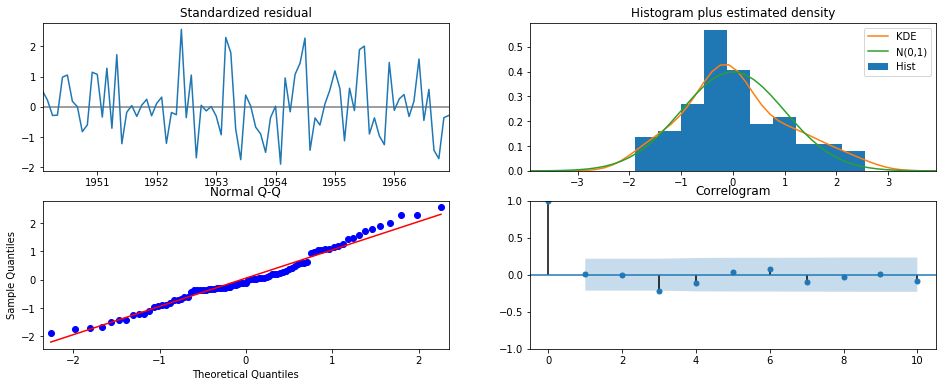

In [8]:
results.plot_diagnostics()

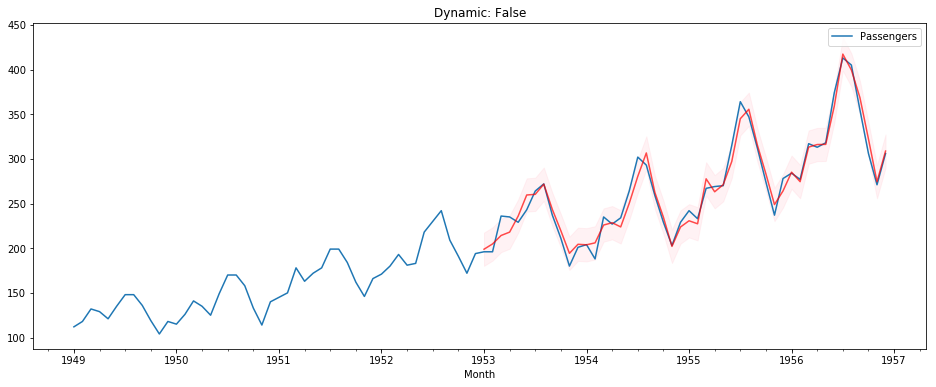

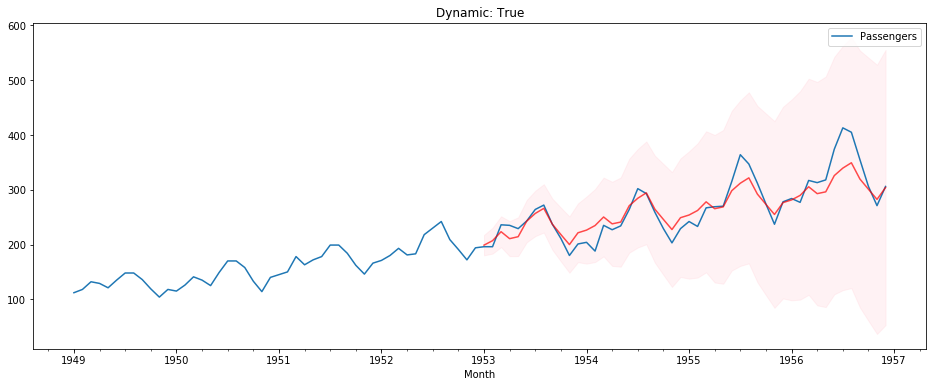

In [13]:
# Forecast, Static
for dynamic_opt in [False, True]:
    pred = results.get_prediction(start=pd.to_datetime('1953-01-01'), dynamic=dynamic_opt)
    pred_ci = pred.conf_int()


    ax = y_train.plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=.7)

    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='pink', alpha=.2)
    
    plt.title('Dynamic: {}'.format(dynamic_opt))
    plt.show()

## Interpreting the Confidence Interval
Copied from [machinelearningmastery](https://machinelearningmastery.com/time-series-forecast-uncertainty-using-confidence-intervals-python/):

> The alpha argument on the forecast() function specifies the confidence level. It is set by default to alpha=0.05, which is a 95% confidence interval. This is a sensible and widely used confidence interval.

> An alpha of 0.05 means that the ARIMA model will estimate the upper and lower values around the forecast where there is a only a 5% chance that the real value will not be in that range.

> Put another way, the 95% confidence interval suggests that there is a high likelihood that the real observation will be within the range.

> In the above example, the forecast was 45.878. The 95% confidence interval suggested that the real observation was highly likely to fall within the range of values between 32.167 and 59.590.

> We can tighten the range of likely values a few ways:

> We can ask for a range that is narrower but increases the statistical likelihood of a real observation falling outside of the range. We can develop a model that has more predictive power and in turn makes more accurate predictions.
Further, the confidence interval is also limited by the assumptions made by the model, such as the distribution of errors made by the model fit a Gaussian distribution with a zero mean value (e.g. white noise).

> Extending the example above, we can report our forecast with a few different commonly used confidence intervals of 80%, 90%, 95% and 99%.

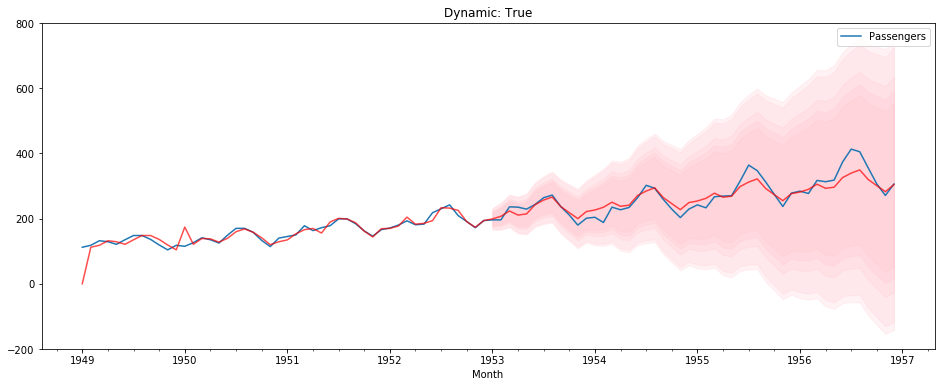

In [22]:
# ------ Alternative Option to For Dynamic Prediction ------
dynamic_start_date = '1953-01-01'
pred = results.get_prediction(dynamic=dynamic_start_date)
ax = y_train.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=.7)

# Fancier confidence
for alpha_val in [0.0005, 0.001, 0.01, 0.025, 0.05]:
    pred_ci = pred.conf_int(alpha=alpha_val)
    ax.fill_between(pred_ci.loc[dynamic_start_date:,:].index,
                    pred_ci.loc[dynamic_start_date:].iloc[:,0],
                    pred_ci.loc[dynamic_start_date:,:].iloc[:,1], color='pink', alpha=.2)


plt.title('Dynamic: {}'.format(dynamic_opt))
plt.show()

## Forecast future values

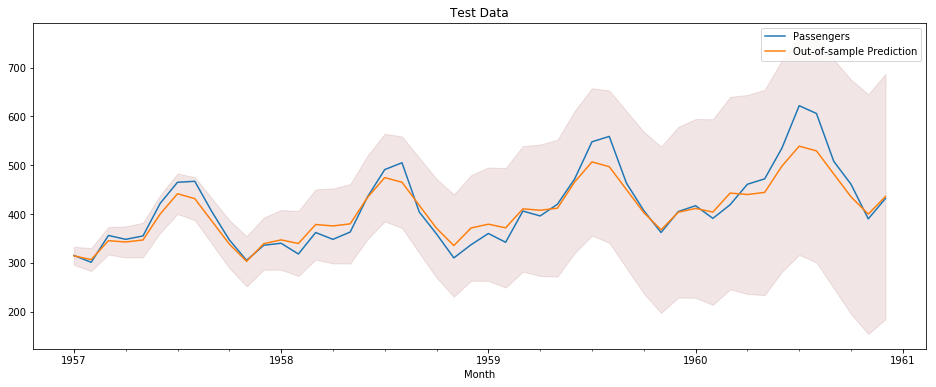

In [11]:
n_future_steps = len(y_test)
pred_test = results.get_forecast(steps=n_future_steps)
pred_test_ci = pred_test.conf_int()


ax = y_test.plot(title='Test Data')
pred_test.predicted_mean.plot(ax=ax, label='Out-of-sample Prediction')
ax.fill_between(pred_test_ci.index, 
                pred_test_ci.iloc[:, 0], pred_test_ci.iloc[:, 1], 
                color='maroon', alpha=0.1)
plt.legend()
plt.show()

## Both in-sample and out-of-sample predictions

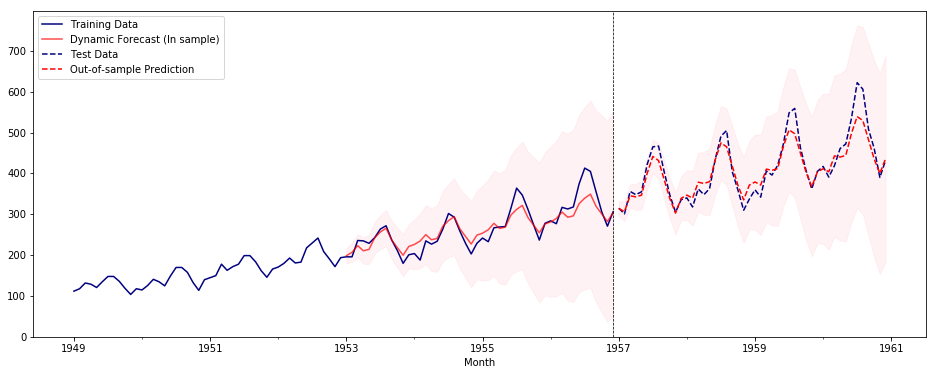

In [12]:
pred = results.get_prediction(start=pd.to_datetime('1953-01-01'), dynamic=True)
pred_ci = pred.conf_int()

# ------------ Training-Set ------------ # 
ax = y_train.rename(columns={'Passengers':'Training Data'}).plot(color='navy')
pred.predicted_mean.plot(ax=ax, label='Dynamic Forecast (In sample)', color='red', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='pink', alpha=.2)

# ------------ Test-Set ------------ # 
y_test.rename(columns={'Passengers':'Test Data'}).plot(ax=ax, color='navy', linestyle='--')
pred_test.predicted_mean.plot(ax=ax, color='red', linestyle='--', label='Out-of-sample Prediction')
ax.fill_between(pred_test_ci.index, 
                pred_test_ci.iloc[:, 0], pred_test_ci.iloc[:, 1], 
                color='pink', alpha=.2)

ax.axvline(x=y_train.index[-1], color='k', linestyle='--', linewidth=0.75)
plt.legend(loc='upper left')
plt.show()

In [15]:
?pred.conf_int(alpha=0.05)
